In [1]:
%matplotlib inline
import math

import numpy as np
import matplotlib.pyplot as plt

from linalg_helper import *

First, we'll simulate a system with 10 dimensions, 1 unstable eigenvalue and all others stable

In [213]:
dim = 100
A = make_random_diagonal_matrix(dim, 1, 0.7, 1)
print('Eigenvalues of matrix')
for i in range(dim):
    print(A[i, i])
C = make_random_subspace(dim, dim)
x_init = np.ones(dim)
x = simulate_free_response(A, 20, x_init)
x_obs = (C.dot(x.T)).T
print('\nActual states')
#plot_state_trace(x)
print('Observed through matrix')
#plot_state_trace(x_obs)



Eigenvalues of matrix
1.37828240555736
0.2876129695137346
0.3237917622422669
0.173522376482161
0.30814141520039
0.1265640035199019
0.1634605051552549
0.11784613241663944
0.0249210656429864
0.03998842174520633
0.029989515373154137
0.000656993903453959
0.011436798452039619
0.008309413912993606
0.005404526699066353
0.003350037658992309
0.0027779407448095383
0.0033944235477908844
0.002357203724533508
0.0017914518754198418
0.001242027509978876
0.0008144477139786193
5.591580689637504e-05
5.03695473846216e-05
0.000192691766983648
0.00013172943414504904
3.843659060029792e-05
9.992340933585953e-05
8.162462264234497e-05
3.817374478436572e-05
1.621647191744533e-05
1.732610540568794e-05
1.4238085499049657e-05
2.369824912569304e-06
5.212238141229204e-06
4.645412758372364e-06
2.083326623430147e-06
1.1000451567026343e-06
1.1534386400141984e-06
1.9376104527405716e-06
8.174331012969801e-07
3.838319795330261e-07
1.5450362889105907e-07
2.2971994490519047e-07
1.689171612105322e-07
-2.418321471192527e-08
-

Given random rotation of the state, all outputs will seem to diverge, or begin exhibiting the diverging eigenvalue. The probability distribution for this observation is unspecified. Next, we will examine if we get similar qualitative results/equivalency by simulating with random eigenvectors vs. some randomly rotated actuation vector

In [214]:
Q = make_random_subspace(dim, dim)

In [215]:
N = 100
A_bar = Q @ A @ Q.T
x1 = simulate_free_response(A_bar, 20, x_init)
#plot_state_trace(x1)
x2 = simulate_free_response(A_bar, N, x_init)
#plot_state_trace(x2)

Asymptotic behavior doesn't show up until after a while in the unstable system.

Having one coordinate transform in between our random observation direction of the state and just observing it in the diagonalized form doesn't seem all that different.

In [216]:
trials = 10
obs_vecs = np.zeros([(N+1)*trials, dim])

for i in range((N+1)*trials):
    obs_vecs[i,:] = make_random_direction(dim).reshape([1, dim])

Text(0.5,1,'Absolute value of projections with eigenvalue envelope, for short time span')

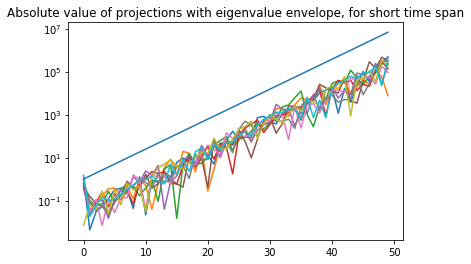

In [223]:
t_final = 50
lambda_vec = np.array([A[0,0] ** n for n in range(t_final)])

obs = np.zeros([N+1, 0])

for i in range(trials):
    obs_curr = obs_vecs[(N+1)*i:(N+1)*(i+1), :]
    obs_vec = np.abs(np.diagonal(obs_curr @ x2.T))
    obs = np.hstack((obs, obs_vec.reshape([N+1, 1])))
    plt.plot(range(t_final), obs_vec[0:t_final])
plt.plot(range(t_final), lambda_vec)
plt.yscale('log')
plt.title('Absolute value of projections with eigenvalue envelope, for short time span')

Is the envelope of our observations of interest? Yes! (empirircally so) There's something happening here, but maybe there's a really simple straightforward explanation. Maybe it's that since the largest state is the one blowing up, the observation vectors that give the maximal dot products on the fringe/envelope will be in greatest alignment with the blowing up eigenvector? So if we can isolate the envelope somehow (look to make the variation convex)

It looks like it's possible to under estimate the eigenvalue based on some part of the dot products. For now, maybe try to convexify (move all points that are lower in the middle of a set of 3 to the average of the 2 points on the exterior) Additionally, would orthogonalization help at all? (Since after n observations due to probabalistic orthogonality, we're bound to be able to write all subsequent measurements in terms of a basis - not necessarily orthogonal?)

Can we look at with k largest eigenvalues, if we can see piece wise linearity based on initial conditions and certain eigenvalues dominating others in the short time span as they grow?

Why is the envelope sometimes exceeded? Is this a shift/translation in log/multiply in normal scale, or is this something more fundamental? Does this interfere with upper bounds?

## "Smoothing" by maximums

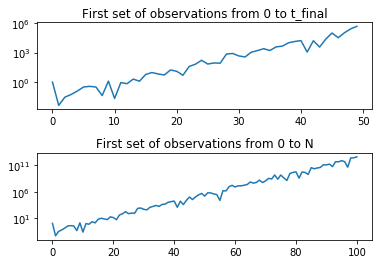

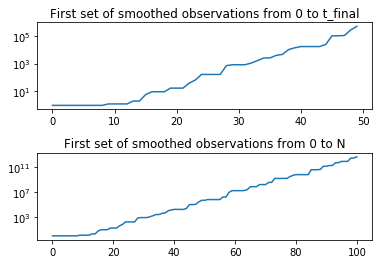

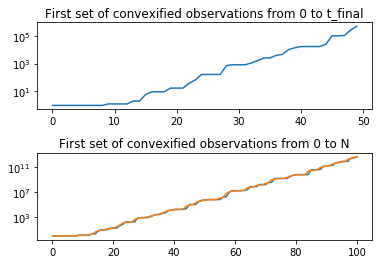

In [224]:
obs1 = np.array(obs[:,0])

fig, ax = plt.subplots(2)
ax[0].plot(range(t_final), obs1[0:t_final])
ax[0].set_yscale('log')
ax[0].set_title('First set of observations from 0 to t_final')
ax[1].plot(range(N+1), obs1)
ax[1].set_yscale('log')
ax[1].set_title('First set of observations from 0 to N')
fig.subplots_adjust(hspace=0.5)

for i in range(N):
    if obs1[i+1] < obs1[i]:
        obs1[i+1] = obs1[i]

fig, ax = plt.subplots(2)
ax[0].plot(range(t_final), obs1[0:t_final])
ax[0].set_yscale('log')
ax[0].set_title('First set of smoothed observations from 0 to t_final')
ax[1].plot(range(N+1), obs1)
ax[1].set_yscale('log')
ax[1].set_title('First set of smoothed observations from 0 to N')
fig.subplots_adjust(hspace=0.5)

# Have to think more about how to do this
convexified = np.array(obs1)
for i in range(N-1):
    convexified[i+1] = (convexified[i] + convexified[i+2])/2
    
fig, ax = plt.subplots(2)
ax[0].plot(range(t_final), obs1[0:t_final])
ax[0].set_yscale('log')
ax[0].set_title('First set of convexified observations from 0 to t_final')
ax[1].plot(range(N+1), obs1)
ax[1].set_yscale('log')
ax[1].set_title('First set of convexified observations from 0 to N')
fig.subplots_adjust(hspace=0.5)

plt.plot(range(N+1), convexified)